## Used Car Price Prediction_Regression

model age 2020-2015

In [70]:
# to handle datasets
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# to evaluate the models
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [71]:
# load dataset
df= pd.read_csv('train-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [72]:
df.shape

(6019, 14)

Data has 6019 rows and 14 columns.

**Feature Description**
* Name: The brand and model of the car.
* Location: The location in which the car is being sold or is available for purchase.
* Year: The year or edition of the model.
* Kilometers_Driven: The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type: The type of fuel used by the car. (Petrol / Diesel / Electric / CNG / LPG)
* Transmission: The type of transmission used by the car. (Automatic / Manual)
* Owner_Type: Whether the ownership is Firsthand, Second hand or other.
* Mileage: The standard mileage offered by the car company in kmpl or km/kg
* Engine: The displacement volume of the engine in cc.
* Power: The maximum power of the engine in bhp.
* Seats: The number of seats in the car.
* New_Price: The price of a new car of the same model.
* Price: The price of the used car in INR Lakhs.

In [73]:
# let's inspect the type of variables in pandas
df.dtypes

Unnamed: 0             int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

There are a mixture of categorical and numerical variables. Numerical are those of type int and float. Categorical those of type object.

There are 9 categorical variables and 5 numerical variables

## Data Cleaning and preprocessing

In [74]:
# percentage of null values
(df.isnull().sum()/len(df))*100

Unnamed: 0            0.000000
Name                  0.000000
Location              0.000000
Year                  0.000000
Kilometers_Driven     0.000000
Fuel_Type             0.000000
Transmission          0.000000
Owner_Type            0.000000
Mileage               0.033228
Engine                0.598106
Power                 0.598106
Seats                 0.697790
New_Price            86.310018
Price                 0.000000
dtype: float64

86.31% of the `New_Price` column has null values and a few null values are present in `Mileage`, `Engine`, `Power` and `Seat` columns.

As there are more than 86% of missing value in `New_Price` column we can drop this feature.

In [75]:
df.columns

Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
       'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
       'Seats', 'New_Price', 'Price'],
      dtype='object')

We can remove the `Unnamed: 0` column as it only gives the serial numbers of the data. 

In [76]:
data = df.drop('Unnamed: 0',axis=1)

There are 1876 Unique car names in the `Name` column. So creating a new column `Manufacturer` by extracting the manufacturer of the
from the `Name` column. For this we need to simply extract the string before the space. 

**Name**

In [77]:
# str.split() by space
data['Name'] = data['Name'].apply(lambda x: x.split(" ")[0])
#renaming column Name to Manufacturer 
data.rename(columns = {'Name':'Manufacturer'}, inplace = True)

In [78]:
data['Manufacturer'].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Smart', 'Ambassador', 'Isuzu', 'ISUZU', 'Force', 'Bentley',
       'Lamborghini'], dtype=object)

Notice that Isuzu in few columns is in capitals.So, replacing 'ISUZU' with 'Isuzu'

In [79]:
data['Manufacturer'] = data['Manufacturer'].replace('ISUZU','Isuzu')

**Mileage**

In [80]:
#null values in mileage column
print('Number of Electric car records: ',len(data[data['Fuel_Type']=='Electric']))
data[data['Mileage'].isnull()==True][['Fuel_Type','Mileage']]

Number of Electric car records:  2


,Fuel_Type,Mileage
4446,Electric,NaN
4904,Electric,NaN


There are only 2 missing values in the Mileage column. We cannot impute the missing value as the these are for Electric car and there are only 2 records of electric cars in the data. So dropping the records with missing values for Electric car.

In [81]:
data =  data.dropna(axis=0, subset=['Mileage'])

There are two measurement units of mileage are included in the dataset i.e., km/kg and kmpl in mileage column. As km/kg is used for non liquid fuels it might not be justified to convert them into kmpl units. 

so, creating a new column called 'Mileage_units'.

In [82]:
Mileage = data["Mileage"].str.split(" ", expand = True)
data['Mileage'] = Mileage[0].astype(float)
data['Mileage_units'] = Mileage[1]

In [83]:
len(data[data['Mileage']==0])

68

There are 68 rows with Mileage value as zero. Replacing with mode of the Mileage values with respect to the Manufacturer.

In [84]:
data[data['Mileage']==0]['Manufacturer'].unique()

array(['Land', 'Mercedes-Benz', 'Hyundai', 'Honda', 'Ford', 'Volkswagen',
       'Smart', 'Maruti', 'Mahindra', 'Toyota', 'Skoda', 'Audi', 'Fiat'],
      dtype=object)

In [85]:
Manufacturer = ['Land', 'Mercedes-Benz', 'Hyundai', 'Honda', 'Ford', 'Volkswagen',
        'Maruti', 'Mahindra', 'Toyota', 'Skoda', 'Audi', 'Fiat']
for c in Manufacturer:
    a = ((data['Manufacturer'] == c) & (data['Mileage'].isnull()))
    data.loc[a,'Mileage'] = data.loc[a, 'Mileage'].fillna(data[data['Manufacturer'] == c]['Mileage'].mode()[0])

Replaced all the Zeros except for one row with Manufacturer as 'Smart'. As it contains only one record, so could not use mode to immpute the zero value. Instead replaced with the value of mean of Mileage of all the records with similar 'Fuel_Type', 'Transmission' and 'Price'.

In [86]:
data['Mileage'] = data['Mileage'].replace(0,
                                           data[(data['Fuel_Type']=='Diesel') & (data['Transmission']=='Automatic') & 
                                                (data['Price']<4)]['Mileage'].mean())

**Engine** 

In [87]:
data['Engine'] = data["Engine"].str.split(" ", expand = True)[0].astype(float)

In [88]:
data[data['Engine'].isnull()]

,Manufacturer,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_units
194,Honda,Ahmedabad,2007,60006,Petrol,Manual,First,13.30,NaN,NaN,NaN,NaN,2.95,kmpl
208,Maruti,Kolkata,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN,NaN,2.11,kmpl
733,Maruti,Chennai,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN,NaN,1.75,kmpl
749,Land,Mumbai,2008,55001,Diesel,Automatic,Second,13.30,NaN,NaN,NaN,NaN,26.50,kmpl
1294,Honda,Delhi,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN,NaN,3.20,kmpl
1327,Maruti,Hyderabad,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN,NaN,5.80,kmpl
1385,Honda,Pune,2004,115000,Petrol,Manual,Second,13.30,NaN,NaN,NaN,NaN,1.50,kmpl
1460,Land,Coimbatore,2008,69078,Petrol,Manual,First,13.30,NaN,NaN,NaN,NaN,40.88,kmpl
2074,Maruti,Pune,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN,NaN,3.15,kmpl
2096,Hyundai,Coimbatore,2004,52146,Petrol,Manual,First,13.30,NaN,NaN,NaN,NaN,1.93,kmpl


In [89]:
df[df['Engine'].isnull()]['Name'].unique()

array(['Honda City 1.5 GXI', 'Maruti Swift 1.3 VXi',
       'Land Rover Range Rover 3.0 D', 'Honda City 1.3 DX',
       'Maruti Swift 1.3 ZXI',
       'Land Rover Range Rover Sport 2005 2012 Sport',
       'Maruti Swift 1.3 LXI', 'Hyundai Santro LP zipPlus',
       'Toyota Etios Liva V', 'Maruti Swift 1.3 VXI ABS',
       'BMW 5 Series 520d Sedan', 'Hyundai Santro GLS II - Euro II',
       'Maruti Wagon R Vx', 'Honda CR-V AT With Sun Roof',
       'Fiat Punto 1.3 Emotion', 'Hyundai Santro Xing XG',
       'Honda Jazz Select Edition', 'Fiat Punto 1.2 Dynamic',
       'Fiat Punto 1.4 Emotion'], dtype=object)

Honda City 1.5 GXI = 1493cc, 84bhp, 5 (https://www.cartrade.com/marutisuzuki-cars/swift-old/vxi-1-3)
Maruti Swift 1.3 VXi = 1197, 81.8, 5 (https://www.cardekho.com/overview/Maruti_Swift/Maruti_Swift_AMT_VXI.htm)
Land Rover Range Rover 3.0 D = 2993, 255bph, 5 (https://www.carwale.com/landrover-cars/range-rover/30voguediesel/)
Honda City 1.3 DX = 1298,  (https://www.cardekho.com/overview/Honda_City_2000-2003/Honda_City_2000-2003_1.3_DX.htm)
Maruti Swift 1.3 ZXI = 1197, 84, 5 (https://www.cartrade.com/marutisuzuki-cars/swift-old/zxi-1-3)

In [90]:
data =  data.dropna(axis=0, subset=['Engine'])

In [91]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


**Power**

In [92]:
data['Power'] = data["Power"].str.split(" ", expand = True)

There are some 'null' values in `Power` column replacing 'null' with NaN.

In [93]:
data['Power'] = data['Power'].replace('null',np.NaN)

In [94]:
Manufacturer = ['Ford', 'Hyundai', 'Maruti', 'Volkswagen', 'Tata', 'Toyota', 'Porsche', 'Fiat', 'Chevrolet', 
                'Mahindra', 'Nissan','Mercedes-Benz', 'Honda', 'Audi', 'Skoda']
for c in Manufacturer:
    a = ((data['Manufacturer'] == c) & (data['Power'].isnull()))
    data.loc[a,'Power'] = data.loc[a, 'Power'].fillna(data[data['Manufacturer'] == c]['Power'].mode()[0])

In [95]:
data['Power'] = data['Power'].astype(float)

In [96]:
data['Power'] = data['Power'].replace(np.NaN,
                                           data[(data['Fuel_Type']=='Diesel') & (data['Transmission']=='Automatic') & 
                                                (data['Price']<4)]['Power'].mean())

**Seats**

In [97]:
Manufacturer = ['Honda', 'Maruti', 'Ford', 'Land', 'Hyundai', 'Toyota', 'BMW','Fiat']
for c in Manufacturer:
    a = ((data['Manufacturer'] == c) & (data['Seats'].isnull()))
    data.loc[a,'Seats'] = data.loc[a, 'Seats'].fillna(data[data['Manufacturer'] == c]['Seats'].mode()[0])

In [98]:
data[data['Seats']==0]

,Manufacturer,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_units
3999,Audi,Hyderabad,2012,125000,Petrol,Automatic,First,10.5,3197.0,174.33,0.0,NaN,18.0,kmpl


We have one row with Seats as Zero, which is not possible to replacing with mode of the Seats with respect to the Manufacturer. 

In [99]:
data['Seats'] = data['Seats'].replace(0,data[data['Manufacturer'] == 'Audi']['Seats'].mode()[0])

In [100]:
data['Seats'].value_counts()

5.0     5019
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
Name: Seats, dtype: int64

Treated all the columns with Null values except `New_Price` column. Dropping this column as it contains over 83% of the null values.

In [101]:
data = data.drop('New_Price',axis=1)

In [102]:
data.isnull().sum().sum()

0

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5981 entries, 0 to 6018
Data columns (total 13 columns):
Manufacturer         5981 non-null object
Location             5981 non-null object
Year                 5981 non-null int64
Kilometers_Driven    5981 non-null int64
Fuel_Type            5981 non-null object
Transmission         5981 non-null object
Owner_Type           5981 non-null object
Mileage              5981 non-null float64
Engine               5981 non-null float64
Power                5981 non-null float64
Seats                5981 non-null float64
Price                5981 non-null float64
Mileage_units        5981 non-null object
dtypes: float64(5), int64(2), object(6)
memory usage: 654.2+ KB


***Outliers***

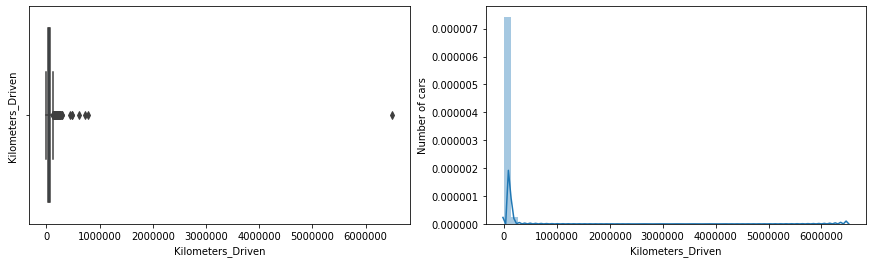

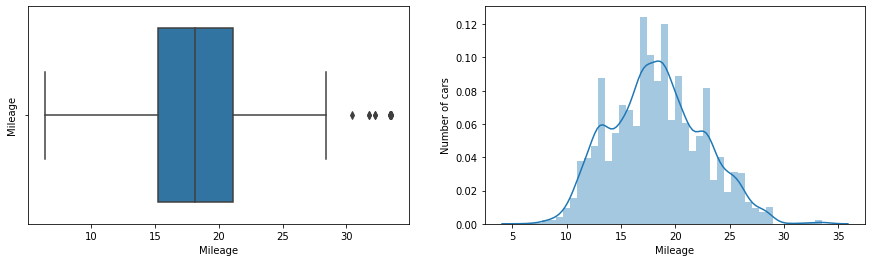

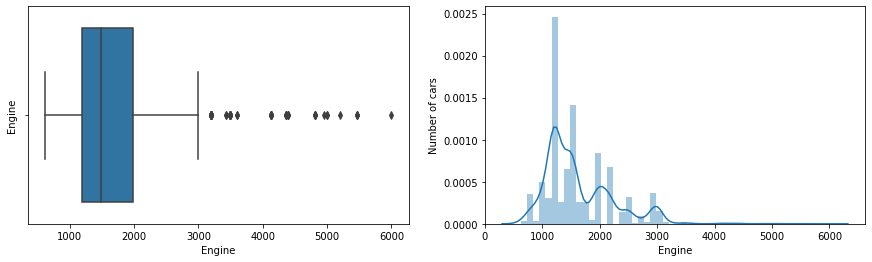

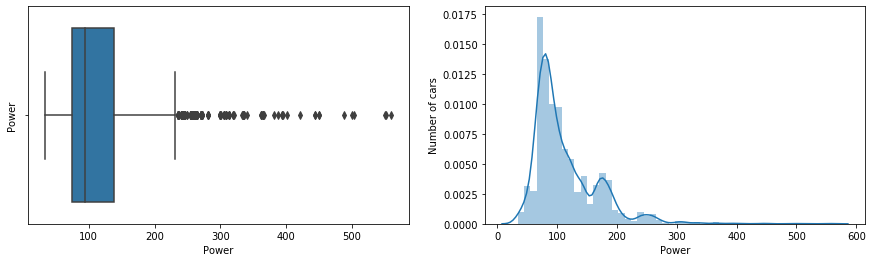

In [104]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution
num = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']
for var in num:
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot((data[var]))
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot((data[var]))
    fig.set_ylabel('Number of cars')
    fig.set_xlabel(var)

    plt.show()

Continuous variables seem to contain outliers. In addition, the variables are not normally distributed. If we are planning to build linear regression, we might need to tackle these to improve the model performance. 

In [105]:
data = data.drop(data[data['Kilometers_Driven']>6000000].index, axis=0)

Removed an outlier row from the data with 'Kilometers_Driven' greater than 6000000.

In [106]:
data.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000,5980.000000
mean,2013.382441,57610.947826,18.302406,1621.276589,112.832039,5.279431,9.485851
std,3.249258,37900.964821,4.189916,600.906139,53.660609,0.805782,11.180077
min,1998.000000,171.000000,6.400000,624.000000,34.200000,2.000000,0.440000
25%,2011.000000,33927.000000,15.200000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,53000.000000,18.160000,1493.000000,93.700000,5.000000,5.650000
75%,2016.000000,73000.000000,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,775000.000000,33.540000,5998.000000,560.000000,10.000000,160.000000


In [107]:
data.shape

(5980, 13)

## Exploratory Data Analysis

#### Visualization of dependent Variable

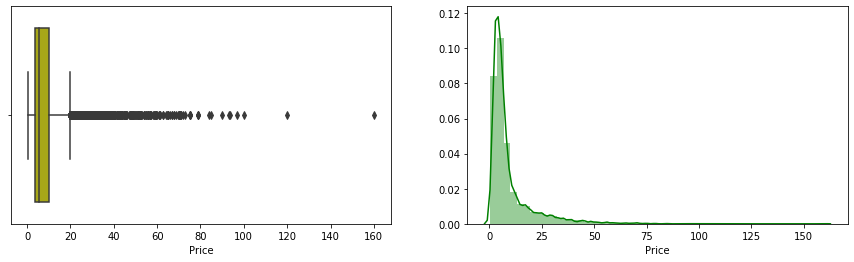

In [108]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax = ax.flatten()

sns.boxplot(data['Price'],color='y',ax=ax[0])
sns.distplot(data['Price'],color='g',ax=ax[1])

plt.show()

Our target variable is rightly skewed, skewness is due to presence of high priced cars and may lead to heteroscadasticity of residuals which makes one of the assumption of the linear regression to fail. 

This can rectified by using transformations.

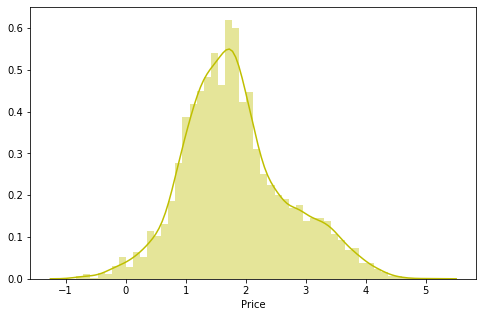

In [109]:
plt.figure(figsize=(8,5))
sns.distplot((np.log(data['Price'])),color='y')
plt.show()

Log transformation reduces the skewness, so we will transform the variable before modelling.

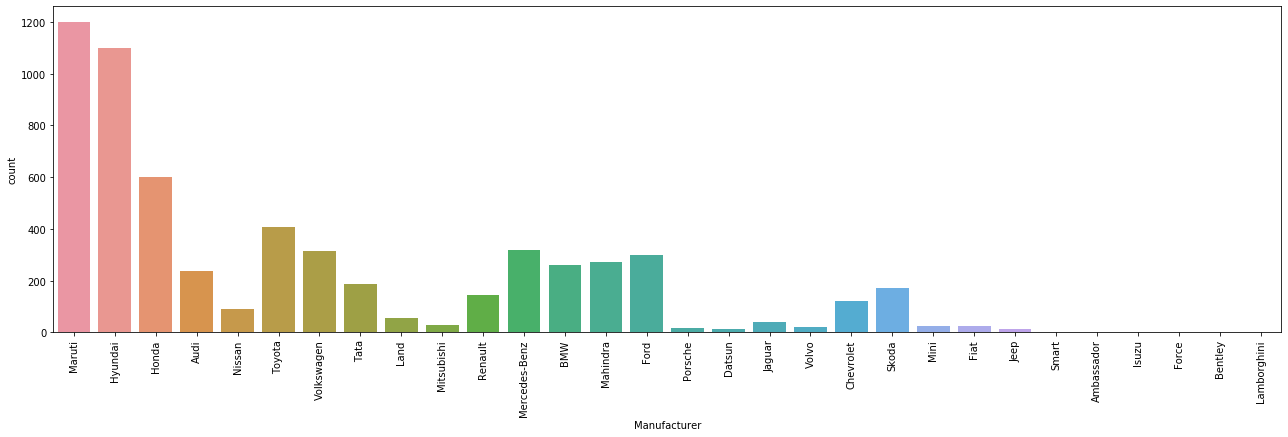

In [110]:
plt.figure(figsize=(22,6))
a=sns.countplot(data['Manufacturer'])
a.tick_params(axis="x",labelrotation=90)
plt.show()

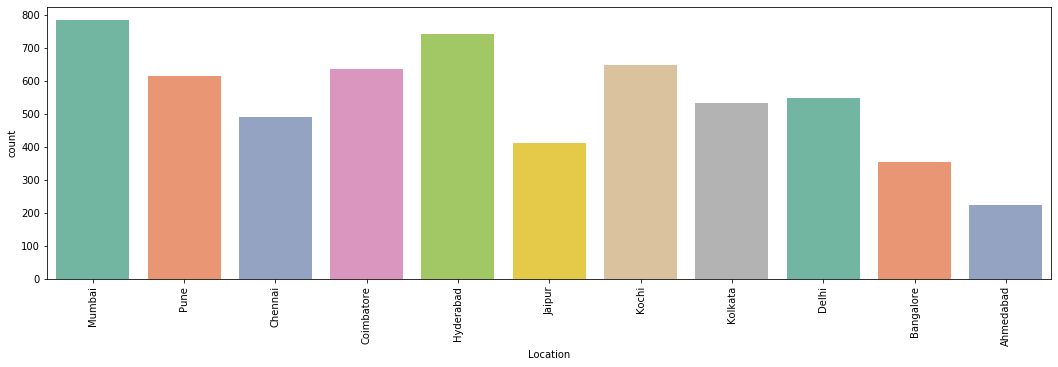

In [111]:
plt.figure(figsize=(18,5))
a=sns.countplot(data['Location'],palette="Set2")
a.tick_params(axis="x",labelrotation=90)
plt.show()

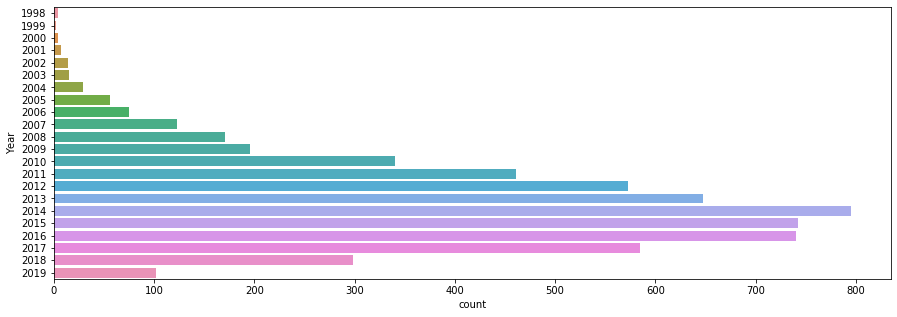

In [112]:
plt.figure(figsize=(15,5))
a=sns.countplot(y = data['Year'])
#a.tick_params(axis="y",labelrotation=90)
plt.show()

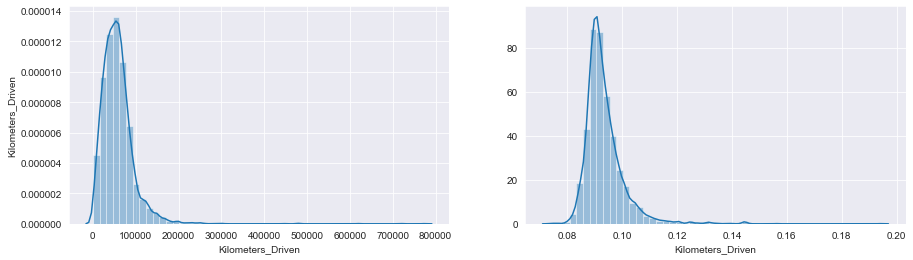

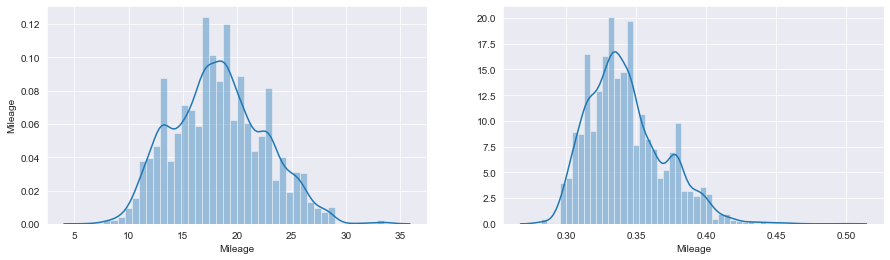

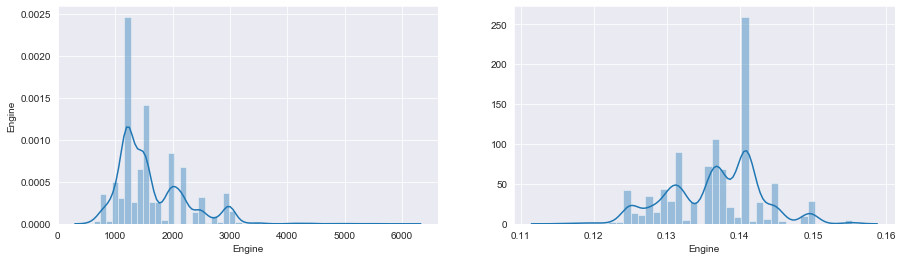

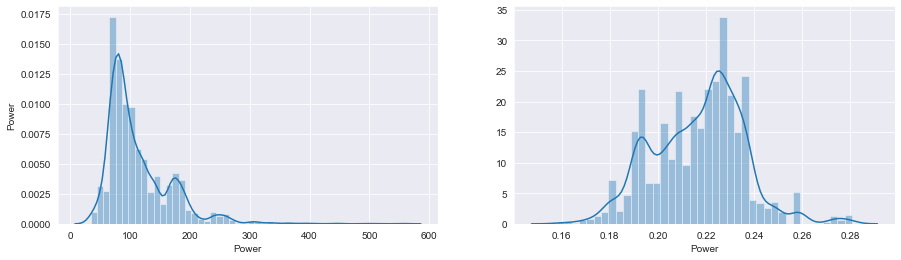

In [178]:
num = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']
for var in num:
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    fig = sns.distplot((data[var]))
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(1/np.log1p(data[var]))
    fig.set_xlabel(var)

    plt.show()

In [114]:
data.head()

,Manufacturer,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Mileage_units
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,km/kg
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,kmpl
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,kmpl
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,kmpl
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,kmpl


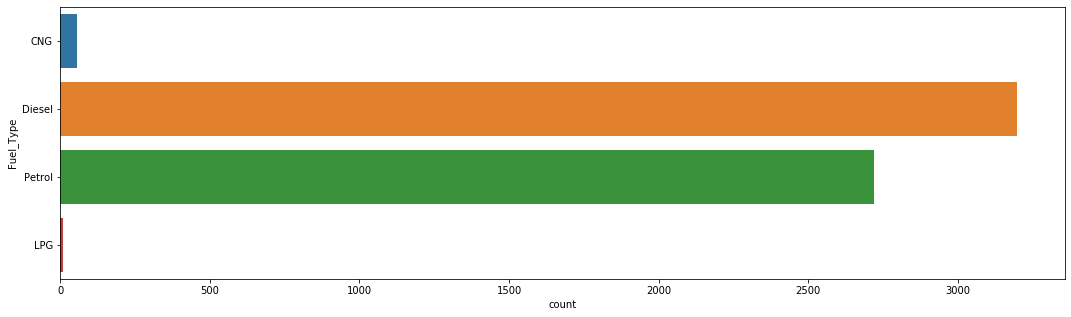

In [115]:
plt.figure(figsize=(18,5))
sns.countplot(y = data['Fuel_Type'])
plt.show()

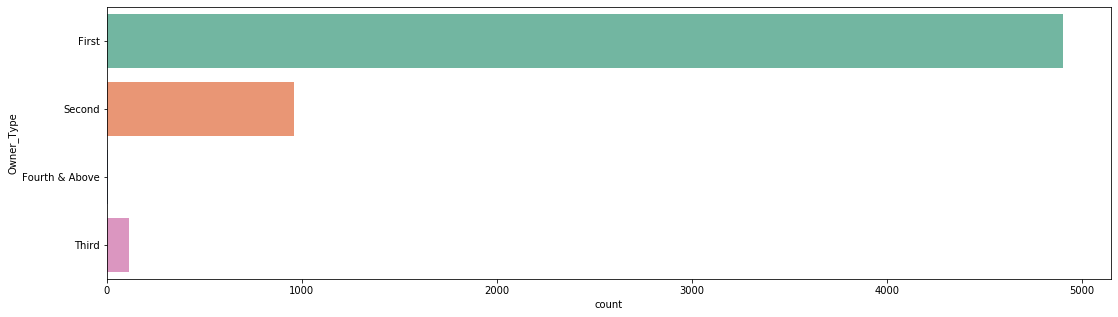

In [116]:
plt.figure(figsize=(18,5))
sns.countplot(y = data['Owner_Type'],palette="Set2")
plt.show()

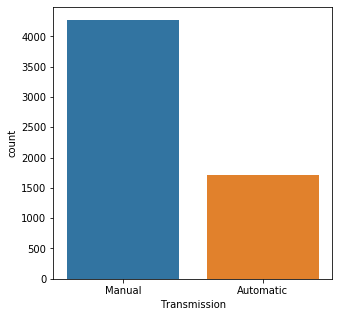

In [117]:
plt.figure(figsize=(5,5))
sns.countplot(data['Transmission'])
plt.show()

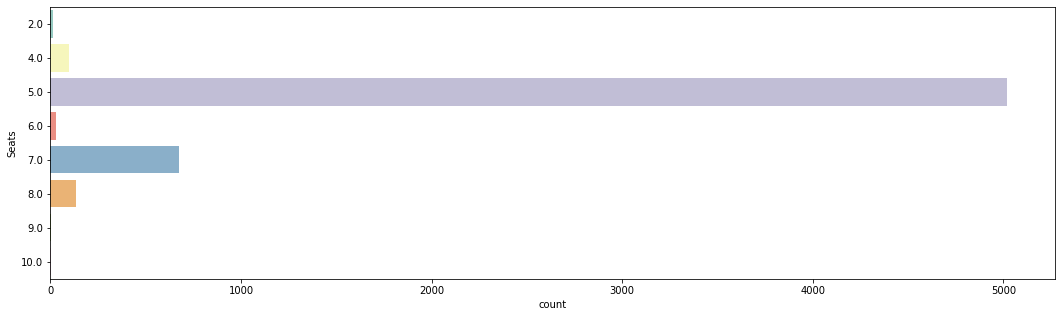

In [118]:
plt.figure(figsize=(18,5))
sns.countplot(y = data['Seats'],palette="Set3")
plt.show()

### Data Preparation

In [119]:
data.head()

,Manufacturer,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Mileage_units
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,km/kg
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,kmpl
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,kmpl
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,kmpl
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,kmpl


In [120]:
data.Owner_Type.value_counts()

First             4904
Second             957
Third              111
Fourth & Above       8
Name: Owner_Type, dtype: int64

In [121]:
data['Owner_Type'] = data['Owner_Type'].replace({'First':1,'Second':2,'Third':3,'Fourth & Above':4})

In [122]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data["Year"]=le.fit_transform(data["Year"])

In [123]:
data = pd.get_dummies(data, prefix_sep='_', drop_first=True)

In [124]:
data.head()

,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer_Audi,Manufacturer_BMW,...,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Mileage_units_kmpl
0,12,72000,1,26.60,998.0,58.16,5.0,1.75,0,0,...,0,0,0,1,0,0,0,0,1,0
1,17,41000,1,19.67,1582.0,126.20,5.0,12.50,0,0,...,0,0,0,0,1,1,0,0,1,1
2,13,46000,1,18.20,1199.0,88.70,5.0,4.50,0,0,...,0,0,0,0,0,0,0,1,1,1
3,14,87000,1,20.77,1248.0,88.76,7.0,6.00,0,0,...,0,0,0,0,0,1,0,0,1,1
4,15,40670,2,15.20,1968.0,140.80,5.0,17.74,1,0,...,0,0,0,0,0,1,0,0,0,1


In [187]:
X = data.drop('Price',axis=1)
y = data.Price

## Feature Selection

###  Backward elimination

In [126]:
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const                          2.137172e-01
Year                          2.007893e-189
Kilometers_Driven              8.332616e-21
Owner_Type                     8.369481e-02
Mileage                        5.061361e-05
Engine                         1.424609e-06
Power                          4.961670e-92
Seats                          2.739090e-01
Manufacturer_Audi              9.656130e-01
Manufacturer_BMW               9.185999e-01
Manufacturer_Bentley           6.441795e-01
Manufacturer_Chevrolet         9.023965e-02
Manufacturer_Datsun            6.233640e-02
Manufacturer_Fiat              1.181224e-01
Manufacturer_Force             6.709909e-02
Manufacturer_Ford              1.281729e-01
Manufacturer_Honda             7.913026e-02
Manufacturer_Hyundai           1.090239e-01
Manufacturer_Isuzu             3.676532e-02
Manufacturer_Jaguar            1.981678e-01
Manufacturer_Jeep              1.568249e-01
Manufacturer_Lamborghini       1.205856e-16
Manufacturer_Land              1

* All the variables are given as input and eventually we remove the features one by one which is not creating impact to the model
* Performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature

In [127]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Manufacturer_Chevrolet', 'Manufacturer_Datsun', 'Manufacturer_Fiat', 'Manufacturer_Force', 'Manufacturer_Ford', 'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Isuzu', 'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lamborghini', 'Manufacturer_Land', 'Manufacturer_Mahindra', 'Manufacturer_Maruti', 'Manufacturer_Mercedes-Benz', 'Manufacturer_Mini', 'Manufacturer_Mitsubishi', 'Manufacturer_Nissan', 'Manufacturer_Porsche', 'Manufacturer_Renault', 'Manufacturer_Skoda', 'Manufacturer_Tata', 'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo', 'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore', 'Location_Hyderabad', 'Location_Jaipur', 'Location_Kolkata', 'Location_Pune', 'Fuel_Type_Petrol']


In [128]:
len(selected_features_BE)

38

### Assumptions of Linear Regression

In [185]:
X = (data[['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Manufacturer_Chevrolet', 'Manufacturer_Datsun', 'Manufacturer_Fiat', 'Manufacturer_Force', 'Manufacturer_Ford', 'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Isuzu', 'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lamborghini', 'Manufacturer_Land', 'Manufacturer_Mahindra', 'Manufacturer_Maruti', 'Manufacturer_Mercedes-Benz', 'Manufacturer_Mini', 'Manufacturer_Mitsubishi', 'Manufacturer_Nissan', 'Manufacturer_Porsche', 'Manufacturer_Renault', 'Manufacturer_Skoda', 'Manufacturer_Tata', 'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo', 'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore', 'Location_Hyderabad', 'Location_Jaipur', 'Location_Kolkata', 'Location_Pune', 'Fuel_Type_Petrol']])
y = np.log(data.Price)

In [186]:
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1881.
Date:                Wed, 01 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:57:04   Log-Likelihood:                 9.3670
No. Observations:                5980   AIC:                             59.27
Df Residuals:                    5941   BIC:                             320.4
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0204      0.046      0.446      0.656      -0.069       0.110
Year                           0.1316      0.001    105.853      0.000       0.129       0.134
Kilometers_Driven           -8.89e-07   1.03e-07     -8.590      0.000   -1.09e-06   -6.86e-07
Mileage                       -0.0231      0.001    -16.766      0.000      -0.026      -0.020
Engine                         0.0002   1.67e-05     10.074      0.000       0.000       0.000
Power                          0.0053      0.000     30.119      0.000       0.005       0.006
Manufacturer_Chevrolet        -0.9308      0.027    -34.177      0.000      -0.984      -0.877
Manufacturer_Datsun           -1.0336      0.070    -14.725      0.000      -1.171      -0.896
Manufacturer_Fiat             -0.8765      0.051    -17.142      0.000      -0.977      -0.776
Manufacturer_Force            -0.4864      0.141     -3.452      0.001      -0.763      -0.210
Manufacturer_Ford             -0.6867      0.021    -32.298      0.000      -0.728      -0.645
Manufacturer_Honda            -0.5526      0.018    -29.929      0.000      -0.589      -0.516
Manufacturer_Hyundai          -0.6107      0.018    -34.520      0.000      -0.645      -0.576
Manufacturer_Isuzu            -0.8783      0.142     -6.206      0.000      -1.156      -0.601
Manufacturer_Jaguar            0.0069      0.040      0.173      0.862      -0.072       0.085
Manufacturer_Jeep             -0.4692      0.064     -7.344      0.000      -0.594      -0.344
Manufacturer_Lamborghini      -0.3287      0.246     -1.337      0.181      -0.810       0.153
Manufacturer_Land              0.2233      0.034      6.482      0.000       0.156       0.291
Manufacturer_Mahindra         -0.7361      0.022    -33.462      0.000      -0.779      -0.693
Manufacturer_Maruti           -0.5959      0.019    -31.741      0.000      -0.633      -0.559
Manufacturer_Mercedes-Benz     0.0320      0.018      1.809      0.071      -0.003       0.067
Manufacturer_Mini              0.4887      0.049      9.919      0.000       0.392       0.585
Manufacturer_Mitsubishi       -0.3916      0.050     -7.855      0.000      -0.489      -0.294
Manufacturer_Nissan           -0.6505      0.030    -21.472      0.000      -0.710      -0.591
Manufacturer_Porsche          -0.2118      0.060     -3.539      0.000      -0.329      -0.094
Manufacturer_Renault          -0.6555      0.026    -25.334      0.000      -0.706      -0.605
Manufacturer_Skoda            -0.5059      0.023    -21.860      0.000      -0.551      -0.460
Manufacturer_Tata             -1.0911      0.025    -44.368      0.000      -1.139      -1.043
Manufacturer_Toyota           -0.3785      0.021    -17.980      0.000      -0.420      -0.337
Manufacturer_Volkswagen       -0.6319      

##### Assumption 1- No autocorrelation


1) No Auto correlation. 

Test needed : Durbin- Watson Test.
    * It's value ranges from 0-4. If the value of Durbin- Watson is Between 0-2, it's known as Positive Autocorrelation.
    * If the value ranges from 2-4, it is known as Negative autocorrelation.
    * If the value is exactly 2, it means No Autocorrelation.

For a good linear model, it should have low or no autocorrelation.

we can see here the values of Dubrin-Watson test (test for normality): 2.005 (Almost No autocorrelation)
    
From the graph below, we can easily see that there is Almost No autocorrelation.

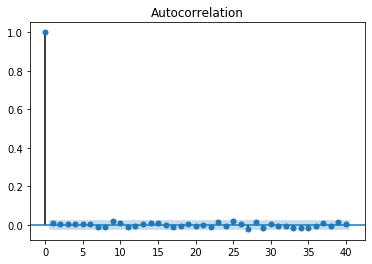

In [131]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
acf.show()

##### Assumption 2- Normality of Residuals

2) The second assumption is the Normality of Residuals. 

For this we prefer the Jarque Bera test. For a good model, the residuals should be normally distributed.
The higher the value of Jarque Bera test , the lesser the residuals are normally distributed.
We generally prefer a lower value of jarque bera test.

The Jarque–Bera test is a goodness-of-fit test of whether sample data 
have the skewness and kurtosis matching a normal distribution.
And jarque-bera test (test for normality) : 42056.703 

In [132]:
from scipy import stats
print(stats.jarque_bera(lin_reg.resid))

(33613.94729311298, 0.0)


The critical chi square value at the 5% level of significance is 5.99. If the computed value exceeds this value the null hypothesis is rejected.

In this case the computed value of the JB statistic 42056.703021843285 is very much greater than 5.99. Thus we reject the null hypothesis that the error terms are normally distributed.

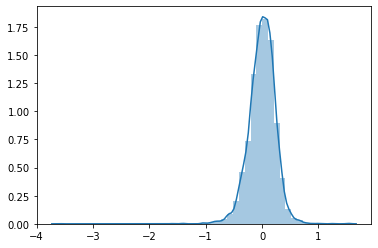

In [133]:
import seaborn as sns

sns.distplot(lin_reg.resid)
plt.show()

##### Asssumption 3 - Linearity of residuals

Here we have 2 options. Either we can plot the observed values Vs predicted values and plot the Residual Vs predicted values and see the linearity of residuals.
OR
We can go for rainbow test. Let's look both of them one by one.

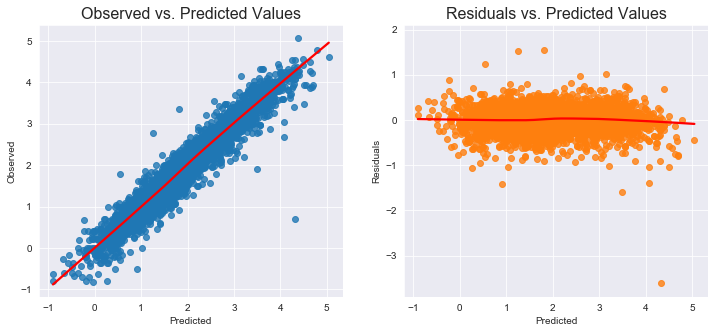

In [134]:
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (12.0, 5.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y)  

* To detect nonlinearity one can inspect plots of observed vs. predicted values or residuals vs. predicted values. 
* The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot or 
around horizontal line in the latter one. 
* n both cases with a low linearity of residuals can be seen.

#### Rainbow test 

It is done to check the linearity of the residuals for a linear regression model.
Linearity of residuals is preferred.

In [135]:
import statsmodels.api as sm
sm.stats.diagnostic.linear_rainbow(res=lin_reg, frac=0.5)

(0.9919627557575846, 0.5870064807463823)

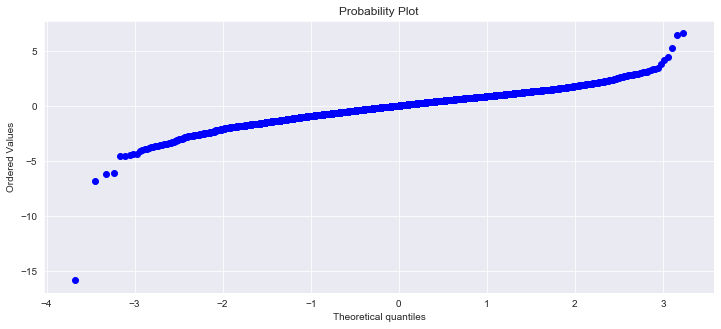

In [136]:
import scipy.stats as stats
import pylab
from statsmodels.graphics.gofplots import ProbPlot
st_residual = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_residual, dist="norm", plot = pylab)
plt.show()

    EXPECTATION : THE MEAN VALUE OF THE RESIDUALS SHOULD BE ZERO.
    LET's CHECK

In [137]:
lin_reg.resid.mean()

-1.8213498342373422e-13

Very much close to zero. -4.182762607161433e-12

So, linearity is present.

##### Assumption 4 -  Homoscedasticity_test(using goldfeld test) OR (Beusch-Wagon Test)
Homoscedacity :: If the residuals are symmetrically distributed across the trend , then it is called as homoscedacious.

Heteroscedacity :: If the residuals are not symmetric across the trend, then it is called as heteroscedacious. In this the residuals can form an arrow shape or any other non symmetrical shape

This test is based on the hytpothesis testing where null and alternate hypothesis are:
* H0 = constant variance among residuals. (Homoscedacity)
* Ha = Heteroscedacity.

The residuals should be homoscedacious.

##### Goldfeld Test

[('F statistic', 1.110316578086014), ('p-value', 0.002278062534121216)]

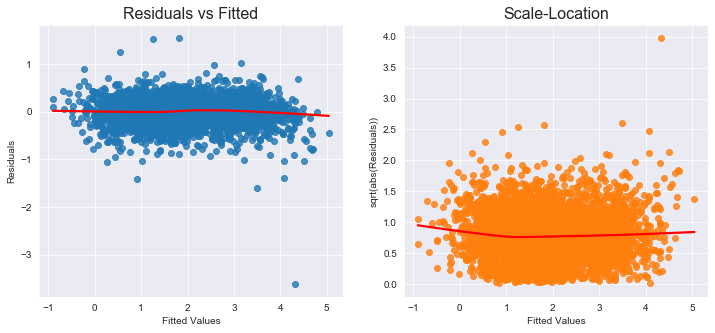

In [138]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (12.0, 5.0)

model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal
fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals')
sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them the null hypothesis assumes 
homoscedasticity and a p-value below a certain level (like 0.05)
indicates we should reject the null in favor of heteroscedasticity.

Here, p value is less than 0.05 so, it is homoscedasticity distribution.
H0 = constant variance (Homoscedacity)
Ha = Heteroscedacity

##### Assumption 5- NO  MULTI COLLINEARITY

The interpretation of VIF is as follows: the square root of a given variable’s VIF shows how much larger the standard error is,
compared with what it would be if that predictor were uncorrelated with the other features in the model.
If no features are correlated, then all values for VIF will be 1.

In [139]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns)

,vif
Year,2.005862
Kilometers_Driven,1.589414
Owner_Type,1.264383
Mileage,3.881345
Engine,11.039321
Power,9.804303
Seats,2.576414
Manufacturer_Audi,230.307655
Manufacturer_BMW,253.954858
Manufacturer_Bentley,2.071104


So, multicollinearity exists.

In [140]:
### Linear Regression - Machine Learning

In [141]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=45)

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score,mean_squared_error,mean_absolute_error
lr=LinearRegression()
lr.fit(X_train,y_train)
ytrain_pred=lr.predict(X_train)
print('R2 of train data:  ',r2_score(y_train,ytrain_pred))

ytest_pred=lr.predict(X_test)
print('R2 of test data:  ',r2_score(y_test,ytest_pred))

R2 of train data:   0.9269832217344911
R2 of test data:   0.9280547489956447


## Regularization

In [143]:
from sklearn.linear_model import Lasso,LassoCV,Ridge,RidgeCV,ElasticNet,ElasticNetCV

##### Lasso(L1) Regularization

In [144]:
n_alphas=50
alphas= np.logspace(-2,0)

lasso_cv=LassoCV(alphas=alphas)
lasso_cv.fit(X, y)

lasso_cv.alpha_

0.01

In [146]:
lasso= Lasso(alpha=0.01)
lasso.fit(X_train,y_train)

y_train_pred= lasso.predict(X_train)
y_test_pred=lasso.predict(X_test)

print('R2 of train data:  ',r2_score(y_train,ytrain_pred))
print('R2 of test data:  ',r2_score(y_test,ytest_pred))

R2 of train data:   0.9269832217344911
R2 of test data:   0.9280547489956447


##### Ridge Regularization

In [147]:
n_alphas=50
alphas= np.logspace(-2,0)

ridge_cv=RidgeCV(alphas=alphas,store_cv_values=True)
ridge_cv.fit(X, y)

ridge_cv.alpha_

0.6866488450042998

In [148]:
ridge= Ridge(alpha=0.0655128556859551)
ridge.fit(X_train,y_train)

y_train_pred= ridge.predict(X_train)
y_test_pred=ridge.predict(X_test)

print('R2 of train data:  ',r2_score(y_train,ytrain_pred))
print('R2 of test data:  ',r2_score(y_test,ytest_pred))

R2 of train data:   0.9269832217344911
R2 of test data:   0.9280547489956447


##### Elastic Net regression 

In [149]:
# Let's perform a cross-validation to find the best combination of alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [150]:
cv_model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
             n_alphas=100, n_jobs=-1, normalize=True, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

In [151]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00001151
Optimal l1_ratio: 0.900
Number of iterations 246


In [152]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(X_train, y_train)

ElasticNet(alpha=1.1505094704635316e-05, copy_X=True, fit_intercept=True,
           l1_ratio=0.9, max_iter=246, normalize=True, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [153]:
print(r2_score(y_train, model.predict(X_train))) # training data performance

0.9269141876242681


In [154]:
print(r2_score(y_test, model.predict(X_test))) # test data performance

0.9277469996029999
